In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-03-28 11:07:37.896146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 11:07:38.023535: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 11:07:38.642398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 11:07:38.642456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [5]:
import numpy as np
node_num = 16
training_id = 0
weight = np.load('learn_output/weight_%d_%d.npy' % (node_num, training_id), allow_pickle=True)
x_train = weight[:-1,:]
y_train = weight[1:,:]
for training_id in range(1, 10):
    weight = np.load('learn_output/weight_%d_%d.npy' % (node_num, training_id), allow_pickle=True)
    x_train = np.concatenate((x_train, weight[:-1,:]), axis = 0)
    y_train = np.concatenate((y_train, weight[1:,:]), axis = 0)

In [6]:
np.shape(x_train)

(1990, 466)

In [7]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[64, 64], n_psi_train=32, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [8]:
dic = DicNN(n_input = np.shape(x_train)[1], layer_sizes=[128, 128])
inputs_x = Input((np.shape(x_train)[1],))
model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x))

2023-03-28 11:07:39.813703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
@tf.function
def eigenloss(matrix, static_num, epsilon):
    eigvalues = tf.linalg.eigvals(matrix)
    static_values, dynamic_values = eigvalues[:static_num], eigvalues[static_num:]
    E1 = tf.reduce_sum(tf.abs(static_values - 1)**2)
    dynamic_values = tf.where(tf.abs(dynamic_values) < epsilon, tf.zeros_like(dynamic_values), dynamic_values)
    E2 = tf.reduce_sum(tf.abs(dynamic_values)**2)
    return E1, E2

In [10]:
inputs_x = Input((np.shape(x_train)[1],))
inputs_y = Input((np.shape(y_train)[1],))
psi_x = model_psi(inputs_x)
psi_y = model_psi(inputs_y)
k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
outputs_x = k_layer(psi_x)
outputs = outputs_x - psi_y
model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs)

In [11]:
inputs_x = Input((np.shape(x_train)[1],))
psi_x = model_psi(inputs_x)
inputs_kpsi = Input((dic.n_psi_train,))
model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
model_auto = Model(inputs = inputs_x, outputs = model_inv_psi(psi_x))

In [12]:
input_x = tf.keras.layers.Input(shape=(x_train.shape[1],))
input_y = tf.keras.layers.Input(shape=(y_train.shape[1],))
output_auto = model_auto(input_x)
output_koopman = model_koopman([input_x, input_y])
combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[output_auto, output_koopman])

In [13]:
def custom_loss(alpha, beta, gamma, epsilon, static_num, model_auto, model_koopman):
    def loss(y_true, y_pred):
        
        # Compute the maximum eigenvalue of the k_layer
        k_layer = model_koopman.get_layer('k_layer')
        matrix = k_layer.trainable_variables[0]
        E1, E2 = eigenloss(matrix, static_num, epsilon)
        
        # Compute the Koopman operator loss
        koopman_loss = tf.keras.losses.MSE(y_pred[1], y_true[1])
    
        # Compute the reconstruction loss
        recon_loss = tf.keras.losses.MSE(y_pred[0], y_true[0])
        
        # Compute the final loss
        return alpha * koopman_loss + beta * recon_loss + gamma[0] * E1 + gamma[1] * E2
    
    return loss

In [14]:
batch_size = 128
epochs = 500
alpha = 0.5
beta = 0.5
# gamma = [0.05,0.05]
gamma = [0,0]
epsilon = 0.8
static_num = 3

In [15]:
combined_model.compile(optimizer='adam', loss=custom_loss(alpha, beta, gamma, epsilon, static_num, model_auto, model_koopman))

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
y_train_scaled = scaler.transform(y_train)

In [17]:
combined_model.fit([x_train_scaled, y_train_scaled], [x_train_scaled, tf.zeros_like(model_psi(x_train_scaled))], epochs = epochs, batch_size = batch_size)

Epoch 1/500
16/16 [==============================] - 2s 8ms/step - loss: 7.3063 - model_3_loss: 1.7422 - model_1_loss: 5.5641
Epoch 2/500
16/16 [==============================] - 0s 7ms/step - loss: 3.8239 - model_3_loss: 1.1026 - model_1_loss: 2.7213
Epoch 3/500
16/16 [==============================] - 0s 7ms/step - loss: 1.9937 - model_3_loss: 0.8243 - model_1_loss: 1.1693
Epoch 4/500
16/16 [==============================] - 0s 7ms/step - loss: 1.9523 - model_3_loss: 0.9533 - model_1_loss: 0.9990
Epoch 5/500
16/16 [==============================] - 0s 7ms/step - loss: 1.5256 - model_3_loss: 0.7088 - model_1_loss: 0.8169
Epoch 6/500
16/16 [==============================] - 0s 7ms/step - loss: 1.3535 - model_3_loss: 0.7139 - model_1_loss: 0.6397
Epoch 7/500
16/16 [==============================] - 0s 7ms/step - loss: 1.0760 - model_3_loss: 0.6010 - model_1_loss: 0.4750
Epoch 8/500
16/16 [==============================] - 0s 7ms/step - loss: 1.0783 - model_3_loss: 0.5332 - model_1_loss:

16/16 [==============================] - 0s 7ms/step - loss: 0.0756 - model_3_loss: 0.0424 - model_1_loss: 0.0331
Epoch 130/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0550 - model_3_loss: 0.0317 - model_1_loss: 0.0232
Epoch 131/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0489 - model_3_loss: 0.0286 - model_1_loss: 0.0203
Epoch 132/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0438 - model_3_loss: 0.0299 - model_1_loss: 0.0139
Epoch 133/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0427 - model_3_loss: 0.0312 - model_1_loss: 0.0115
Epoch 134/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0438 - model_3_loss: 0.0286 - model_1_loss: 0.0152
Epoch 135/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0528 - model_3_loss: 0.0407 - model_1_loss: 0.0121
Epoch 136/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0656 - model_3_loss: 0.0419 - model_1_los

16/16 [==============================] - 0s 7ms/step - loss: 0.0320 - model_3_loss: 0.0221 - model_1_loss: 0.0099
Epoch 258/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0357 - model_3_loss: 0.0271 - model_1_loss: 0.0086
Epoch 259/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0244 - model_3_loss: 0.0170 - model_1_loss: 0.0074
Epoch 260/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0179 - model_3_loss: 0.0132 - model_1_loss: 0.0048
Epoch 261/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0263 - model_3_loss: 0.0197 - model_1_loss: 0.0065
Epoch 262/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0306 - model_3_loss: 0.0247 - model_1_loss: 0.0058
Epoch 263/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0314 - model_3_loss: 0.0241 - model_1_loss: 0.0073
Epoch 264/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0318 - model_3_loss: 0.0241 - model_1_los

16/16 [==============================] - 0s 7ms/step - loss: 0.1823 - model_3_loss: 0.1289 - model_1_loss: 0.0534
Epoch 386/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0926 - model_3_loss: 0.0603 - model_1_loss: 0.0323
Epoch 387/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0795 - model_3_loss: 0.0533 - model_1_loss: 0.0262
Epoch 388/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0735 - model_3_loss: 0.0561 - model_1_loss: 0.0175
Epoch 389/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0606 - model_3_loss: 0.0419 - model_1_loss: 0.0186
Epoch 390/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0451 - model_3_loss: 0.0243 - model_1_loss: 0.0209
Epoch 391/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0452 - model_3_loss: 0.0276 - model_1_loss: 0.0176
Epoch 392/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0401 - model_3_loss: 0.0259 - model_1_los

In [18]:
k_layer = model_koopman.get_layer('k_layer')
matrix = k_layer.trainable_variables[0]
eigenvalues, eigenvectors = tf.linalg.eig(matrix)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Extract real and imaginary parts
real_part = np.real(eigenvalues)
imag_part = np.imag(eigenvalues)

In [19]:
eigenvalues

<tf.Tensor: shape=(32,), dtype=complex64, numpy=
array([-0.24507616+0.j        ,  0.04750601+0.2632461j ,
        0.04750601-0.2632461j , -0.03667491+0.16716656j,
       -0.03667491-0.16716656j, -0.07713522+0.j        ,
        0.33454126+0.37062612j,  0.33454126-0.37062612j,
        0.25770074+0.j        ,  0.21524322+0.j        ,
        0.4460876 +0.10361753j,  0.4460876 -0.10361753j,
        0.5618807 +0.j        ,  0.6905519 +0.06277397j,
        0.6905519 -0.06277397j,  0.7666549 +0.j        ,
        0.81831986+0.j        ,  0.91442907+0.03104459j,
        0.91442907-0.03104459j,  0.87547994+0.j        ,
        0.9985927 +0.00693331j,  0.9985927 -0.00693331j,
        0.99673414+0.j        ,  1.0088536 +0.j        ,
        1.0044203 +0.00398749j,  1.0044203 -0.00398749j,
        1.00246   +0.00189761j,  1.00246   -0.00189761j,
        1.0063869 +0.00074651j,  1.0063869 -0.00074651j,
        1.0040811 +0.00266348j,  1.0040811 -0.00266348j], dtype=complex64)>

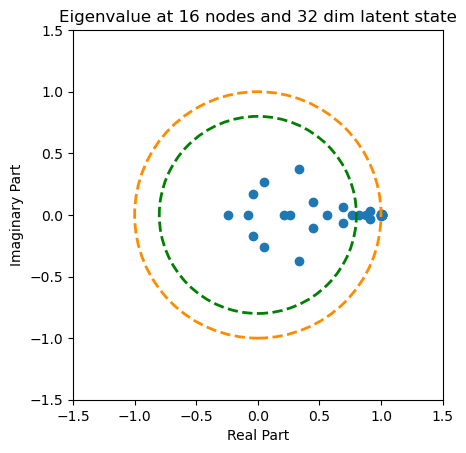

In [20]:
fig, ax = plt.subplots()
ax.scatter(real_part, imag_part)

# Label the axes
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')

# Label the caption
plt.title('Eigenvalue at %d nodes and 32 dim latent state' % node_num)

# Add the unit circle
unit_circle = Circle((0, 0), radius=1, fill=False, linestyle='--', linewidth=2, color = 'darkorange')
half_circle = Circle((0, 0), radius=0.8, fill=False, linestyle='--', linewidth=2, color = 'green')

ax.add_artist(unit_circle)
ax.add_artist(half_circle)


# Set the axis limits to show the full circle
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal')


# Show the plot
plt.show()


In [22]:
U = eigenvectors
U_inv = tf.linalg.inv(U)
U_inv_static = np.zeros(tf.shape(U_inv))
for i in range(len(eigenvalues)):
    eig = eigenvalues[i]
    if tf.abs(eig) > epsilon:
        U_inv_static[i,:] = tf.abs(U_inv[i,:])        

In [21]:
# U = eigenvectors
# U_inv = tf.linalg.inv(U)
# U_inv_static = tf.zeros_like(U_inv)
# for i in range(static_num):
#     U_inv_static = tf.tensor_scatter_nd_update(U_inv_static,
#                                                 indices=[[i]],
#                                                 updates=[tf.abs(eigenvalues[i] * U_inv[i, :])])
# print(U_inv_static)


tf.Tensor(
[[0.02329242+0.j 0.03142685+0.j 0.0200076 +0.j ... 0.14382964+0.j
  0.01192444+0.j 0.03404916+0.j]
 [0.05202407+0.j 0.02592809+0.j 0.19715963+0.j ... 0.14043681+0.j
  0.13705724+0.j 0.09682909+0.j]
 [0.0520242 +0.j 0.0259282 +0.j 0.19715962+0.j ... 0.14043705+0.j
  0.13705724+0.j 0.09682904+0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]], shape=(32, 32), dtype=complex64)


In [22]:
model_psi(x_train_scaled[:1,:])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.19731663,  0.01121156,  0.5505918 ,  0.7119236 , -0.43271193,
         0.44589722,  0.06963895, -0.56004035, -0.43447953,  0.6557389 ,
         0.45861855,  0.21972503, -0.21564569, -0.3520559 , -0.19093528,
        -0.4065676 , -0.5687215 , -0.280802  ,  0.4333609 , -0.14292045,
        -0.21930373,  0.05958398,  0.539366  , -0.28651774,  0.33915028,
        -0.15365338, -0.41353112, -0.08747441, -0.08405096,  0.201535  ,
         0.32425377, -0.5103728 ]], dtype=float32)>

In [24]:
static_para_scaled = model_inv_psi(model_psi(x_train_scaled[200:201,:]) @ tf.math.real(tf.abs(U)) @ U_inv_static)

In [25]:
static_para = scaler.inverse_transform(static_para_scaled)
np.shape(static_para)

(1, 466)

In [25]:
node_num = 16

In [28]:
inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
start_idx = 0
for i, w in enumerate(model.trainable_weights):
    w_shape = w.shape
    print(w_shape)
    w_size = tf.reduce_prod(w_shape)
    end_idx = start_idx + w_size
    w.assign(tf.cast(tf.reshape(static_para[0, start_idx:end_idx], w_shape), tf.float32))
    start_idx = end_idx

(26, 16)
(16,)
(16, 2)
(2,)


In [26]:
from sklearn.decomposition import PCA
import numpy as np
import tensorflow as tf

# Load MNIST data.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train = x_train / 255.0
x_test = x_test / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train))
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train = (y_train < 5)
y_test = (y_test < 5)

# Convert labels to one-hot encoding.
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Track the data type of x_train.
dataType = x_train.dtype
print(f"Data type: {dataType}")

# Track the data type of y_test.
labelType = y_test.dtype
print(f"Data type: {labelType}")

# Print the one-hot encoded label for the first training example.
print(y_train[0])

# Instantiate the training dataset.
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 70% of variance
x_train_reduced = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_reduced = pca.transform(x_test.reshape(x_test.shape[0], -1))

# Print the dimensions of the original and reduced datasets.
print("Original dimensions:", x_train.shape)
print("Reduced dimensions:", x_train_reduced.shape)

Data type: float64
Data type: float32
[1. 0.]
Original dimensions: (60000, 784)
Reduced dimensions: (60000, 26)


In [29]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])        
model.evaluate(x_train_reduced, y_train)

1875/1875 [==============================] - 3s 1ms/step - loss: 3.7719 - accuracy: 0.5250


[3.7718942165374756, 0.5250499844551086]